In [ ]:
from huggingface_hub import login

token = "" #add your token here

login(token=token)

# Evaluation - 100 samples

--- Evaluation Script Started (Mistral Zero-Shot) ---
Timestamp: 2025-05-12 04:14:18
Configuration: NUM_SAMPLES_TO_EVALUATE=50
VERBOSE_LOGGING: False
Generation Params: DO_SAMPLE_GEN=False, MAX_NEW_TOKENS_GEN=300
Tokenizer Max Length: 2048

Loading dataset 'b-mc2/sql-create-context' (split='train')...
Selected 50 samples for evaluation.

=== Loading Fine-Tuned Mistral-7B: /content/drive/MyDrive/Codes_and_models/Mistral_6500/mistral7b-ft-lora-sql-v4-test ===


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


=== Evaluating Fine-Tuned Mistral-7B (Zero-Shot) on 50 samples ===

--- Fine-Tuned Mistral-7B Evaluation Summary ---
  Exact Matches: 35/50 (70.00%)
  Execution Accuracy: 44/50 (88.00%)
Fine-Tuned Mistral-7B resources released.

=== Loading Base Mistral-7B-v0.1: mistralai/Mistral-7B-v0.1 ===
Set pad_token to eos_token for Base Mistral-7B-v0.1 tokenizer.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


=== Evaluating Base Mistral-7B-v0.1 (Zero-Shot) on 50 samples ===

--- Base Mistral-7B-v0.1 Evaluation Summary ---
  Exact Matches: 23/50 (46.00%)
  Execution Accuracy: 39/50 (78.00%)
Base Mistral-7B-v0.1 resources released.

--- Overall Evaluation Script Complete ---
Exact Match comparison plot saved as mistral_exact_match_zero_shot_20250512-043412.png


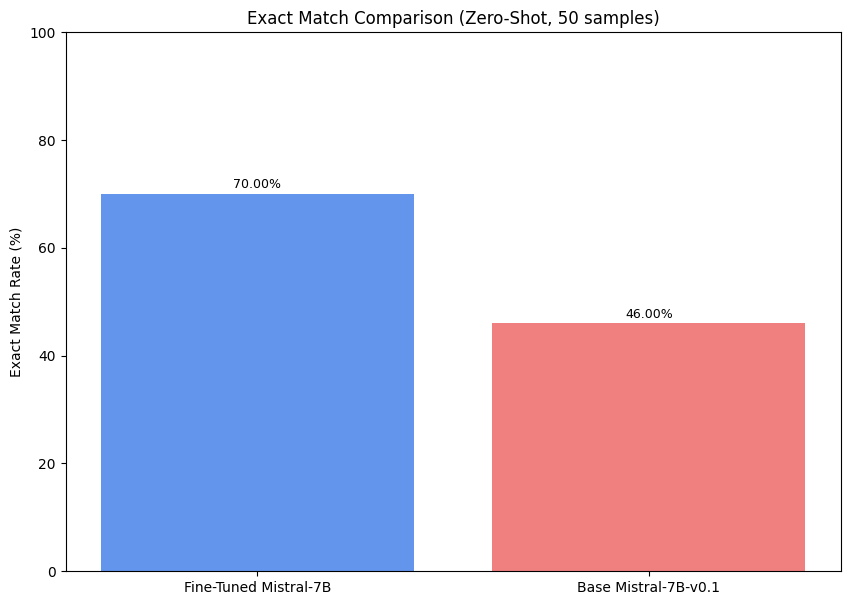

Execution Accuracy comparison plot saved as mistral_execution_accuracy_zero_shot_20250512-043412.png


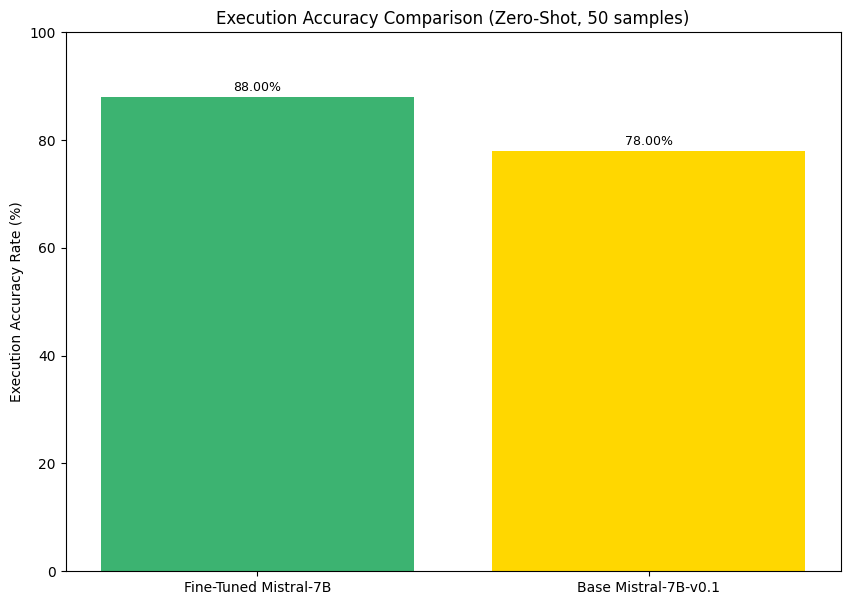

Total script execution time: 1194.59 seconds.


In [7]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import re
import sqlite3
from datasets import load_dataset
from typing import List, Dict, Optional
import numpy as np
import gc
import matplotlib.pyplot as plt
import time

NUM_SAMPLES_TO_EVALUATE = 50
VERBOSE_LOGGING = False
MODEL_MAX_LENGTH = 2048
MAX_NEW_TOKENS_GEN = 300
DO_SAMPLE_GEN = False
TEMPERATURE_GEN = 0.6
TOP_P_GEN = 0.9


def extract_sql_refined(text: str) -> str:
    code_block_match = re.search(r"```(?:sql)?\s*(SELECT\b.*?|INSERT\b.*?|UPDATE\b.*?|DELETE\b.*?|CREATE\b.*?|ALTER\b.*?|DROP\b.*?)\s*```", text, re.DOTALL | re.IGNORECASE)
    if code_block_match:
        sql = code_block_match.group(1).strip()
        if sql.endswith(';'):
            sql = sql[:-1].strip()
        return ' '.join(sql.split())

    example_block_match = re.search(r"###\s*Example:\s*(SELECT\b.*?)(?=\n\n|###\s*\w+:|\Z|View\b|Explanation\b)", text, re.DOTALL | re.IGNORECASE)
    if example_block_match:
        sql = example_block_match.group(1).strip()
        if sql.endswith(';'):
            sql = sql[:-1].strip()
        return ' '.join(sql.split())

    fallback_sql_match_semicolon = re.search(
        r"\b(SELECT\b[^;]+?;|INSERT\b[^;]+?;|UPDATE\b[^;]+?;|DELETE\b[^;]+?;|CREATE\b[^;]+?;|ALTER\b[^;]+?;|DROP\b[^;]+?;)(?!\s*```|\s*###\s*(?:Response|Instruction))",
        text, re.IGNORECASE | re.DOTALL
    )
    if fallback_sql_match_semicolon:
        sql = fallback_sql_match_semicolon.group(1).strip()
        if sql.endswith(';'):
             sql = sql[:-1].strip()
        return ' '.join(sql.split())

    fallback_sql_match_no_semicolon = re.search(
        r"\b(SELECT\b.*?|INSERT\b.*?|UPDATE\b.*?|DELETE\b.*?|CREATE\b.*?|ALTER\b.*?|DROP\b.*?)"
        r"(?=\s*(?:View\b|Explanation\b|Example\b|Note\b|The query\b|This SQL\b|Answer\b|OFFSET\b|LIMIT\b|SQL Query:|Question:|Schema:|###|```|\Z|SELECT\b|INSERT\b|UPDATE\b|DELETE\b|CREATE\b|ALTER\b|DROP\b))",
        text, re.IGNORECASE | re.DOTALL
    )
    if fallback_sql_match_no_semicolon:
        sql = fallback_sql_match_no_semicolon.group(1).strip()
        if sql.endswith(';'):
            sql = sql[:-1].strip()
        return ' '.join(sql.split())

    lines = text.strip().splitlines()
    if lines:
        first_line = lines[0].strip()
        if re.match(r"^(SELECT|INSERT|UPDATE|DELETE|CREATE|ALTER|DROP)\b", first_line, re.IGNORECASE):
            sql_candidate = first_line
            if sql_candidate.endswith(';'):
                sql_candidate = sql_candidate[:-1].strip()
            return ' '.join(sql_candidate.split())
    return ' '.join(text.strip().split())


def setup_database(schema: str) -> Optional[sqlite3.Connection]:
    conn = sqlite3.connect(":memory:")
    cursor = conn.cursor()
    try:
        cursor.executescript(schema)
        conn.commit()
        return conn
    except Exception as e:
        if VERBOSE_LOGGING:
            print(f"DB setup error for schema:\n{schema}\nError: {e}")
        conn.close()
        return None

def execute_sql_query(conn: sqlite3.Connection, sql_query: str) -> Optional[List[tuple]]:
    try:
        cursor = conn.cursor()
        cursor.execute(sql_query)
        results = cursor.fetchall()
        return results
    except Exception as e:
        if VERBOSE_LOGGING:
            print(f"Query execution error for query:\n{sql_query}\nError: {e}")
        return None

def check_execution_accuracy(schema: str, generated_sql: str, gold_sql: str) -> bool:
    if not generated_sql.strip():
        return False

    conn = setup_database(schema)
    if conn is None:
        return False

    res_gen = execute_sql_query(conn, generated_sql)
    if res_gen is None:
        conn.close()
        return False

    res_gold = execute_sql_query(conn, gold_sql)
    if res_gold is None:
        if VERBOSE_LOGGING:
            print(f"Warning: Gold SQL failed to execute. Gold SQL: {gold_sql} on schema:\n{schema}")
        conn.close()
        return False

    conn.close()
    try:
        return sorted(res_gen) == sorted(res_gold)
    except TypeError:
        if VERBOSE_LOGGING:
            print(f"TypeError during result comparison. Gen: {res_gen}, Gold: {res_gold}")
        return res_gen == res_gold


def evaluate_text_to_sql_model_zero_shot(
    model,
    tokenizer,
    samples_to_eval: List[Dict],
    model_name: str = "Model"
) -> Dict:
    exact_matches = 0
    execution_correct = 0
    results_log = []

    if VERBOSE_LOGGING:
        print(f"\n--- Starting Zero-Shot Evaluation for {len(samples_to_eval)} samples with {model_name} ---")

    for i, current_eval_sample in enumerate(samples_to_eval):
        if VERBOSE_LOGGING and (i + 1) % 5 == 0 :
             print(f"--- {model_name} (Zero-Shot) - Processing Sample {i+1}/{len(samples_to_eval)} ---")

        prompt_text = (
            f"Given a database schema and a question, generate the SQL query to answer the question.\n"
            f"Schema:\n{current_eval_sample['context']}\n"
            f"Question:\n{current_eval_sample['question']}\n"
            f"SQL Query:"
        )

        inputs = tokenizer(prompt_text, return_tensors="pt", padding=False, truncation=True, max_length=MODEL_MAX_LENGTH).to(model.device)

        with torch.no_grad():
            generation_args = {
                "max_new_tokens": MAX_NEW_TOKENS_GEN,
                "pad_token_id": tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id,
                "eos_token_id": tokenizer.eos_token_id,
                "do_sample": DO_SAMPLE_GEN,
            }
            if DO_SAMPLE_GEN:
                generation_args["temperature"] = TEMPERATURE_GEN
                generation_args["top_p"] = TOP_P_GEN

            output = model.generate(**inputs, **generation_args)

        input_ids_length = inputs.input_ids.shape[1]
        generated_ids = output[0][input_ids_length:]
        raw_generation = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

        stop_phrases = ["Schema:", "Question:", "\n---\n", "Explanation:", "###", "Given a database schema"]
        for phrase in stop_phrases:
            if phrase in raw_generation:
                raw_generation = raw_generation.split(phrase)[0].strip()

        generated_sql = extract_sql_refined(raw_generation)
        gold_sql = current_eval_sample['answer'].strip()

        gold_sql_for_em_comparison = gold_sql.lower().replace("'", '"')
        generated_sql_for_em_comparison = generated_sql.lower().replace("'", '"')
        is_exact = generated_sql_for_em_comparison == gold_sql_for_em_comparison
        if is_exact:
            exact_matches += 1

        is_exec_correct = check_execution_accuracy(current_eval_sample['context'], generated_sql, gold_sql)
        if is_exec_correct:
            execution_correct += 1

        if VERBOSE_LOGGING:
            print(f"\nSample {i+1} ({model_name}):")
            print(f"  Question: {current_eval_sample['question']}")
            print(f"  Gold SQL: '{gold_sql}'")
            print(f"  Generated SQL (Extracted): '{generated_sql}'")
            print(f"  Raw Gen (first 100): '{raw_generation[:100]}...'")
            print(f"  Exact Match: {is_exact}")
            print(f"  Execution Correct: {is_exec_correct}")

        results_log.append({
            'question': current_eval_sample['question'],
            'schema': current_eval_sample['context'],
            'gold_sql': gold_sql,
            'generated_sql_extracted': generated_sql,
            'raw_model_output': raw_generation,
            'exact_match_after_normalization': is_exact,
            'execution_correct': is_exec_correct,
        })

    if VERBOSE_LOGGING:
        print(f"\n--- {model_name} - Zero-Shot Evaluation Complete ---")

    total_samples_evaluated = len(samples_to_eval)
    return {
        'exact_match_count': exact_matches,
        'execution_correct_count': execution_correct,
        'total_samples': total_samples_evaluated,
        'exact_match_rate': exact_matches / total_samples_evaluated if total_samples_evaluated > 0 else 0,
        'execution_accuracy': execution_correct / total_samples_evaluated if total_samples_evaluated > 0 else 0,
        'results_log': results_log
    }

def main():
    script_start_time = time.time()
    gc.collect()
    torch.cuda.empty_cache()

    print(f"--- Evaluation Script Started (Mistral Zero-Shot) ---")
    print(f"Timestamp: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Configuration: NUM_SAMPLES_TO_EVALUATE={NUM_SAMPLES_TO_EVALUATE}")
    print(f"VERBOSE_LOGGING: {VERBOSE_LOGGING}")
    print(f"Generation Params: DO_SAMPLE_GEN={DO_SAMPLE_GEN}, MAX_NEW_TOKENS_GEN={MAX_NEW_TOKENS_GEN}")
    if DO_SAMPLE_GEN: print(f"  Temperature={TEMPERATURE_GEN}, Top_P={TOP_P_GEN}")
    print(f"Tokenizer Max Length: {MODEL_MAX_LENGTH}")

    try:
        print("\nLoading dataset 'b-mc2/sql-create-context' (split='train')...")
        dataset_full_train = load_dataset("b-mc2/sql-create-context", split="train")

        if len(dataset_full_train) < NUM_SAMPLES_TO_EVALUATE:
            print(f"Error: Dataset 'train' split has {len(dataset_full_train)} samples, "
                  f"but need {NUM_SAMPLES_TO_EVALUATE} for evaluation.")
            return

        dataset_shuffled = dataset_full_train.shuffle(seed=42)
        samples_for_evaluation_list = [dataset_shuffled[i] for i in range(NUM_SAMPLES_TO_EVALUATE)]
        print(f"Selected {len(samples_for_evaluation_list)} samples for evaluation.")

    except Exception as e:
        print(f"Failed to load or process dataset: {e}")
        return

    finetuned_mistral_path = "/content/drive/MyDrive/Codes_and_models/Mistral_6500/mistral7b-ft-lora-sql-v4-test"
    base_mistral_id = "mistralai/Mistral-7B-v0.1"

    all_results_summary = {}

    model_display_name_ft = "Fine-Tuned Mistral-7B"
    print(f"\n=== Loading {model_display_name_ft}: {finetuned_mistral_path} ===")
    try:
        try:
            ft_tokenizer = AutoTokenizer.from_pretrained(finetuned_mistral_path, trust_remote_code=True)
        except OSError:
            print(f"Tokenizer not found in {finetuned_mistral_path}. Attempting to load from {base_mistral_id}.")
            ft_tokenizer = AutoTokenizer.from_pretrained(base_mistral_id, trust_remote_code=True)

        if ft_tokenizer.pad_token is None:
            ft_tokenizer.pad_token = ft_tokenizer.eos_token
            print(f"Set pad_token to eos_token for {model_display_name_ft} tokenizer.")

        ft_model = AutoModelForCausalLM.from_pretrained(
            finetuned_mistral_path,
            device_map="auto",
            torch_dtype=torch.bfloat16
        ).eval()

        print(f"\n=== Evaluating {model_display_name_ft} (Zero-Shot) on {len(samples_for_evaluation_list)} samples ===")
        ft_eval_results = evaluate_text_to_sql_model_zero_shot(ft_model, ft_tokenizer, samples_for_evaluation_list, model_name=model_display_name_ft)

        print(f"\n--- {model_display_name_ft} Evaluation Summary ---")
        print(f"  Exact Matches: {ft_eval_results['exact_match_count']}/{ft_eval_results['total_samples']} ({ft_eval_results['exact_match_rate']:.2%})")
        print(f"  Execution Accuracy: {ft_eval_results['execution_correct_count']}/{ft_eval_results['total_samples']} ({ft_eval_results['execution_accuracy']:.2%})")
        all_results_summary[model_display_name_ft] = ft_eval_results

        del ft_model
        del ft_tokenizer
        gc.collect()
        torch.cuda.empty_cache()
        print(f"{model_display_name_ft} resources released.")
    except Exception as e:
        print(f"Error during {model_display_name_ft} evaluation: {e}")

    model_display_name_base = "Base Mistral-7B-v0.1"
    print(f"\n=== Loading {model_display_name_base}: {base_mistral_id} ===")
    try:
        base_tokenizer = AutoTokenizer.from_pretrained(base_mistral_id, trust_remote_code=True)
        if base_tokenizer.pad_token is None:
            base_tokenizer.pad_token = base_tokenizer.eos_token
            print(f"Set pad_token to eos_token for {model_display_name_base} tokenizer.")

        base_model = AutoModelForCausalLM.from_pretrained(
            base_mistral_id,
            device_map="auto",
            torch_dtype=torch.bfloat16
        ).eval()

        print(f"\n=== Evaluating {model_display_name_base} (Zero-Shot) on {len(samples_for_evaluation_list)} samples ===")
        base_eval_results = evaluate_text_to_sql_model_zero_shot(base_model, base_tokenizer, samples_for_evaluation_list, model_name=model_display_name_base)

        print(f"\n--- {model_display_name_base} Evaluation Summary ---")
        print(f"  Exact Matches: {base_eval_results['exact_match_count']}/{base_eval_results['total_samples']} ({base_eval_results['exact_match_rate']:.2%})")
        print(f"  Execution Accuracy: {base_eval_results['execution_correct_count']}/{base_eval_results['total_samples']} ({base_eval_results['execution_accuracy']:.2%})")
        all_results_summary[model_display_name_base] = base_eval_results

        del base_model
        del base_tokenizer
        gc.collect()
        torch.cuda.empty_cache()
        print(f"{model_display_name_base} resources released.")
    except Exception as e:
        print(f"Error during {model_display_name_base} evaluation: {e}")

    print("\n--- Overall Evaluation Script Complete ---")

    if len(all_results_summary) >= 1 :
        model_names_plot = list(all_results_summary.keys())

        em_rates_plot = [all_results_summary[name]['exact_match_rate'] * 100 for name in model_names_plot]
        ex_ac_rates_plot = [all_results_summary[name]['execution_accuracy'] * 100 for name in model_names_plot]

        timestamp_str = time.strftime("%Y%m%d-%H%M%S")
        num_eval_samples_for_plot = len(samples_for_evaluation_list)

        def create_and_save_plot(metric_name, rates, colors, filename_prefix):
            plt.figure(figsize=(10, 7))
            bars = plt.bar(model_names_plot, rates, color=colors[:len(model_names_plot)])
            plt.ylabel(f'{metric_name} Rate (%)')
            plt.title(f'{metric_name} Comparison (Zero-Shot, {num_eval_samples_for_plot} samples)')
            plt.ylim(0, 100)
            for bar in bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom', fontsize=9)
            plot_filename = f"{filename_prefix}_zero_shot_{timestamp_str}.png"
            plt.savefig(plot_filename)
            print(f"{metric_name} comparison plot saved as {plot_filename}")
            plt.show()

        try:
            create_and_save_plot("Exact Match", em_rates_plot, ['cornflowerblue', 'lightcoral'], "mistral_exact_match")
            create_and_save_plot("Execution Accuracy", ex_ac_rates_plot, ['mediumseagreen', 'gold'], "mistral_execution_accuracy")
        except ImportError:
            print("\nMatplotlib not found or error during plot generation. Skipping plot generation.")
            print("To generate plots, please ensure matplotlib is installed: pip install matplotlib")
        except Exception as e:
            print(f"\nError during plot generation: {e}")
    else:
        print("\nSkipping plot generation as no model evaluation results are available.")

    script_end_time = time.time()
    print(f"Total script execution time: {script_end_time - script_start_time:.2f} seconds.")

if __name__ == "__main__":
    main()